In [1]:
import glob, os
import Colors
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it
import statsmodels.stats.multitest as multi

In [2]:
from matplotlib.patches import Rectangle, Circle

In [3]:
np.random.seed(174612)

# read data

In [4]:
files5d = glob.glob('../mG*5d/rawdata/mG*_spliced*jan19.coutt*')

In [5]:
files5d

['../mG01-20umAP-5d/rawdata/mG01_trim_star_spliced_jan19.coutt.tsv',
 '../mG02-20umAP-5d/rawdata/mG02_trim_star_spliced_jan19.coutt.tsv',
 '../mG03-20umAP-5d/rawdata/mG03_trim_star_spliced_jan19.coutt.tsv',
 '../mG04-08umAP-5d/rawdata/mG04_trim_star_spliced_jan19.coutt.tsv',
 '../mG05-08umAP-5d/rawdata/mG05_trim_star_spliced_jan19.coutt.tsv']

In [6]:
dfs5d = [read_csv(f, sep = '\t', index_col=0).astype(int) for f in files5d]

In [7]:
g_annotate=['Cdx2','Rspo3','Sox1','Sox2','Wnt3a','Fgf8','Uncx','Aldh1a2','Nkx1-2','Cyp26a1', 'Foxb1', 'Ets2',
            'Hes3','Pax6','Irx3','Irx5','Sox21','Dbx1','Dll1','Meox1','Tcf15','Pax3','Ptn','Klf3','Spon1', 'Rab3il1',
          'Mesp2','Ripply2','Dppa5a','Meox1','Tbx6','T', 'Hand1', 'Hand2', 'Gata6', 'Mef2c']

# Select genes present in all samples

In [8]:
def findUbiGenes(dfs):
    genes = []
    for df in dfs:
        genes += list(df.loc[df.sum(axis=1)>0].index)
    cnt = Counter(genes)
    gs = [g for g in cnt if cnt[g]==len(dfs)]
    print(len(cnt), len(gs))
    return gs

In [9]:
g5 = findUbiGenes(dfs5d)

37245 17504


In [10]:
dfs5d = [df.loc[g5] for df in dfs5d]

# number of reads and genes per section

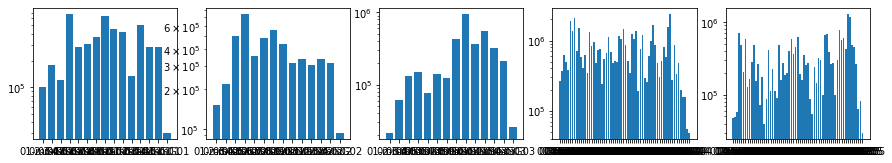

In [11]:
plt.figure(figsize=(3*len(dfs5d),2.4))
for i, df in enumerate(dfs5d):
    plt.subplot(1,len(dfs5d),i+1)
    cnt = df.sum()
    plt.bar(cnt.keys(), cnt)
    plt.yscale('log')
plt.show()

# normalize and prepare data

In [12]:
def removeGenes(df):
    genes = ['ERCC','chrM', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'Rpl', 'Rps','__MT']
    exclude = [idx for idx in df.index for g in genes if g in idx]
    return df.loc[[idx for idx in df.index if idx not in exclude]]

def removeGmGenes(df):
    g = []
    for idx in df.index:
        if 'Gm' in idx:
            gid = idx.rsplit('Gm')[1].rsplit('__')[0]
            if sum([n in [str(r) for r in range(10)] for n in gid]) == len(gid):
                g.append(idx)
    return df.loc[[idx for idx in df.index if idx not in g]]

In [13]:
def filter_norm_dfs(dfs):
#    fdfs = [removeGmGenes(removeGenes(df)) for df in dfs]
    fdfs = [removeGenes(df) for df in dfs]
    fdfs = [df.loc[df.index[df.sum(axis=1)>0]] for df in fdfs]
    nfdfs = [df.sum().mean()*df/df.sum() for df in fdfs]
    return nfdfs

nfdfs5d = filter_norm_dfs(dfs5d)

In [14]:
for i, df in enumerate(nfdfs5d):
    df.to_csv('../mG0' + str(i+1) +'.filtnorm.coutt.tsv', sep = '\t') 

In [15]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [16]:
znfdfs5d = [zscore(df) for df in nfdfs5d]
sznfdfs5d = [scalezscore(df) for df in znfdfs5d]

In [17]:
# for i, df in enumerate(znfdfs5d):
#     df.to_csv('../mG0' + str(i+1) +'.filtnorm.zscore.tsv', sep = '\t') 

In [18]:
[df.shape for df in znfdfs5d]

[(17091, 15), (17091, 14), (17091, 14), (17091, 62), (17091, 63)]

In [19]:
def averageGastruloid(mzdf,n):
    mdf = mzdf.T
    glds = set([c.rsplit('-')[-1] for c in mdf.index])
    mdf['x'] = 0
    for gld in glds:
        idxs = [c for c in mdf.index if gld == c.rsplit('-')[-1]]
        xra = np.linspace(0,1,len(idxs))
        for idx, x in zip(idxs, xra):
            mdf.loc[idx,'x'] = x
    mdf = mdf.sort_values(by = 'x', ascending = True)
    xdf = pd.DataFrame(columns = mdf.columns, index = range(n))
    xra = np.linspace(0,1,n+1)
    for i in range(len(xra)-1):
        idxs = [c for c in mdf.index if xra[i]<mdf.loc[c,'x']<=xra[i+1]]
        xdf.loc[i] = mdf.loc[idxs].mean()
    del xdf['x']
    return xdf.T

In [20]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

In [21]:
avznfdfs5d = averageGastruloid(mergeDfs(znfdfs5d), 14).astype(float)

In [22]:
avznfdfs5d.to_csv('../mGav_E14_zscores.tsv', sep ='\t')

# Identify reproducible genes in each timepoint

## Background model

In [23]:
def simulationCorrelations(n1, n2, N = 5000):
    x1 = np.linspace(0,1,n1)
    x2 = np.linspace(0,1,n2)
    ps = [0 for i in range(N)]
    for i in range(N):
        d1 = np.random.rand(n1)
        d2 = np.random.rand(n2)

        id2 = interp1d(x2, d2, kind='quadratic')
        ps[i] = pearsonr(d1, id2(x1))[0]
    psdf = pd.DataFrame({'corr': sorted(ps), 'cum': np.linspace(0,1, N)})
    psdf['pval'] = 1.-psdf['cum']
    return psdf

## Correlation between genes

In [24]:
def geneCorrelation(df1, df2):
    x1 = 1.0*np.arange(len(df1.columns))/(len(df1.columns)-1)
    x2 = 1.0*np.arange(len(df2.columns))/(len(df2.columns)-1)
    cnt = Counter(list(df1.index) + list(df2.index))
    genes = [g for g in cnt if cnt[g] == 2]
    
    cdf = pd.Series(0, index = genes)
    for g in genes:
        idf2 = interp1d(x2, df2.loc[g].values, kind='quadratic')
        cdf.loc[g] = pearsonr(df1.loc[g], idf2(x1))[0]
    return cdf

In [25]:
def assignPval2corr(cdf, pdf, corrcolname = 'corr'):
    cdf2 = pd.DataFrame(cdf, columns = [corrcolname])
    cdf2['pv'] = 0
    for g in cdf.index:
        pv = cdf.loc[g]
        if (pdf['corr'] >= pv).sum() > 0:
            p0 = pdf[pdf['corr'] >= pv].iloc[0]['pval']
        else:
            p0 = 0.
        if (pdf['corr'] <pv).sum() > 0:
            p1 = pdf[pdf['corr'] < pv].iloc[-1]['pval']
        else:
            p1 = 1.
        cdf2.loc[g,'pv'] = 0.5*(p0+p1)
    cdf2['adj-pv'] = multi.fdrcorrection(cdf2['pv'],  method='indep')[1]
    return cdf2      

In [26]:
def mergeGeneLists(gene_list):
    for x in gene_list:
        gene_list[x].columns = [str(c) + '_' + str(x) for c in gene_list[x].columns]
    ks = list(gene_list.keys())
    mdf = gene_list[ks[0]]
    for i in range(1,len(ks)):
        mdf = mdf.merge(gene_list[ks[i]], how = 'inner', left_index = True, right_index = True)
    return mdf

In [28]:
if not os.path.isfile('../results/geneCorrelations_5dAA.tsv'):
    pv_sim_5d = {}
    corrGenes_5d = {}
    for x, (i1, i2) in enumerate(it.combinations(range(len(znfdfs5d)), 2)):
        pv_sim_5d[(i1, i2)] = simulationCorrelations(n1 = len(znfdfs5d[i1].columns), n2 = len(znfdfs5d[i2].columns))
        corrGenes_5d[(i1, i2)] = geneCorrelation(znfdfs5d[i1], znfdfs5d[i2])
        corrGenes_5d[(i1, i2)] = assignPval2corr(corrGenes_5d[(i1, i2)], pv_sim_5d[(i1,i2)])
    mdf5d = mergeGeneLists(corrGenes_5d)
    mdf5d.to_csv('../results/geneCorrelations_5dAA.tsv', sep = '\t')
else:
    mdf5d = read_csv('../results/geneCorrelations_5dAA.tsv', sep = '\t', index_col = 0)


# Gene selection

## 5dAA

In [30]:
pvth = 0.1; nth = 5
pvcols = [c for c in mdf5d.columns if 'pv_('==c[:4]]
gl_5d = mdf5d.index[mdf5d.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [31]:
len(gl_5d), mdf5d.shape

(1199, (17091, 30))

# check reproducibility

In [32]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [33]:
5*np.sqrt(1000)

158.11388300841895

In [34]:
mdf5d = mergeDfs(znfdfs5d)

## 5dAA 

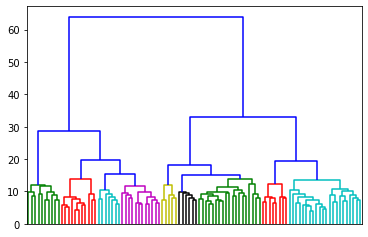

In [35]:
somhcl_5d_df_stlist = comboCluster(mdf5d, gl_5d, cth=15)

In [56]:
somhcl_5d_df_stlist.sort_values(by=['hcl','som']).to_csv('../results/clusters_5d_reprGenes_paperSelection.tsv', sep = '\t')

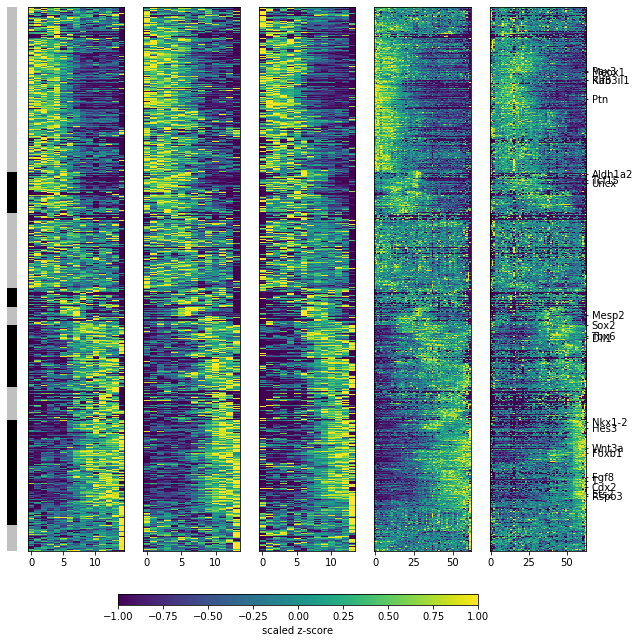

In [36]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize = (10,10))

gene_order = somhcl_5d_df_stlist.sort_values(by=['hcl','som']).index

im = ['' for i in range(5)]
for i, df in enumerate(sznfdfs5d):
    im[i] = ax[i].imshow(df.loc[gene_order][::-1], aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(sznfdfs5d[0].columns)
x0 = -2.5*dx
y0 = len(somhcl_5d_df_stlist)-0.5
for cl in set(somhcl_5d_df_stlist['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (somhcl_5d_df_stlist['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

plt.savefig('../results/heatmap_5d_reprGenes_paperSelection_allReplicates.pdf', bbox_inches = 'tight')

plt.show()

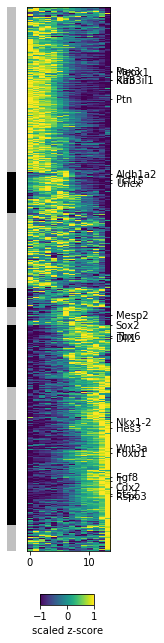

In [37]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (1.5,10))

gene_order = somhcl_5d_df_stlist.sort_values(by=['hcl','som']).index

df = scalezscore(avznfdfs5d)
im = ax.imshow(df.loc[gene_order][::-1], aspect = 'auto')
ax.set_yticks([])
ax.tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax.set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax.set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im, label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(sznfdfs5d[0].columns)
x0 = -2.5*dx
y0 = len(somhcl_5d_df_stlist)-0.5
for cl in set(somhcl_5d_df_stlist['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (somhcl_5d_df_stlist['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax.add_patch(rect)
    y0 -= n

#plt.savefig('../results_postRevJan19/heatmap_5d_reprGenes_paperSelection_avGld.pdf', bbox_inches = 'tight')

plt.show()

In [38]:
set(somhcl_5d_df_stlist['hcl'])

{0, 1, 2, 3, 4, 5, 6, 7, 8}

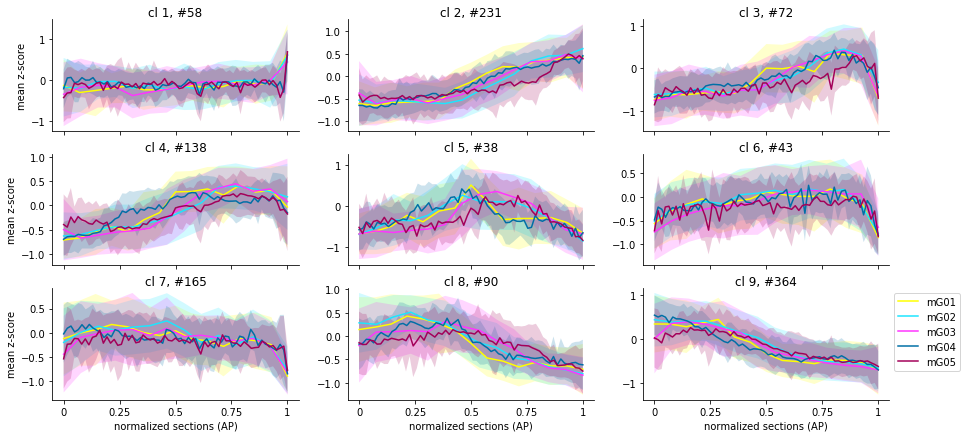

In [39]:
fig = plt.figure(figsize=(15,7))

for cl in set(somhcl_5d_df_stlist['hcl']):
    ax = fig.add_subplot(3,3,cl+1)
    genes = somhcl_5d_df_stlist[somhcl_5d_df_stlist['hcl']==cl].index
    for i, df in enumerate(sznfdfs5d):
        xra = np.linspace(0,1,len(df.columns))
        mu = df.loc[genes].mean()
        mup = mu + df.loc[genes].std()
        mum = mu - df.loc[genes].std()
       
        ax.plot(xra, mu, c = Colors.colors[i])
        ax.fill_between(xra, mup, mum, facecolor=Colors.colors[i], interpolate=True, alpha = 0.2)
#    ax.text(0.1,.9, 'cluster ' + str(cl) +', ' +str(len(genes)), horizontalalignment='left', transform=ax.transAxes)
    ax.set_title('cl '+str(cl+1)+', #'+str(len(genes)), pad = -500)
#    ax.set_xticks(range(120)[::10], range(120)[::10])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0,0.25,0.50,0.75,1]); ax.set_xticklabels([])
    if cl+1 in [1,4,7]:
        ax.set_ylabel('mean z-score')
    if cl >= 6:
        plt.xlabel('normalized sections (AP)')
        ax.set_xticklabels([0,0.25,0.50,0.75,1])
        
plt.legend(['mG01', 'mG02', 'mG03', 'mG04','mG05'], loc = 2, bbox_to_anchor = (1,1))

#plt.savefig('../results_postRevJan19/lineplots_5d_reprGenes_paperSelection.pdf', bbox_inches = 'tight')

plt.show()